In [1]:
# pip install alphagens==0.3.2
# 然后去github网站上把那个数据下载下来

In [1]:
import pandas as pd
import numpy as np
import joblib # >= 1.2.0
import matplotlib.pyplot as plt
import os


In [2]:
from alphagens.factor_utils import get_clean_factor_and_forward_returns, get_clean_factor_and_current_returns
from alphagens.backtest import QuickBackTestor, QuickFactorTestor
from alphagens.utils.metrics import FactorMetrics, StrategyMetrics
from alphagens.data_source.tushare import pro, Stock, Index
from alphagens.calendars import DEFAULT_CALENDAR
import joblib
from alphagens.utils.format_output import df_to_html

ModuleNotFoundError: No module named 'alphagens'

In [4]:
class Context:
    DATA_PATH = "./data"
    START_DATE = "20100101"
    END_DATE = "20180101"
    BENCHMARK = "000300.SH"
    
    trade_dates = DEFAULT_CALENDAR.sessions_in_range(START_DATE, END_DATE)
    REBALANCE_DATES = DEFAULT_CALENDAR.Weekly(trade_dates)

In [5]:
class DataPortal:

    def __init__(self):
        self._all_basic_data: pd.DataFrame = joblib.load(f"{Context.DATA_PATH}/tushare.ex_basic")
        self.prices: pd.DataFrame = self._all_basic_data["close"].unstack().fillna(method='ffill')
        self.universe: list[str] = Index.components(ts_code=Context.BENCHMARK, end_date=Context.END_DATE).index
        self.universe = sorted([x[:-3] for x in self.universe])
    
        self.factors: pd.DataFrame = joblib.load(f"{Context.DATA_PATH}/uqer.factor").loc[Context.trade_dates]
        self.industry_map: pd.Series = joblib.load(f"{Context.DATA_PATH}/uqer.industry_map")

    def history(self, date, symbols: list, field: str, lookback: int = None):
        if lookback is not None:
            slice_dates = DEFAULT_CALENDAR.history(date, lookback)
            return self._all_basic_data.loc[(slice_dates, symbols), field]

    def query_covariance(self, date, symbols, lookback):
        """请注意协方差矩阵的数量级!!!
        """
        if lookback < 2 * len(symbols):
            raise ValueError("lookback must be twice as long as length of symbols")
        slice_data = self.history(date, symbols, "pct_chg", lookback) / 100
        slice_data = slice_data.unstack().fillna(0)
        mean = slice_data.mean(axis=0)
        cov = slice_data.cov()
        return mean, cov
    
    @property
    def factor_names(self):
        return self.factors.columns.to_list()
    
    def factor_get(self, factor_name, dates=None):
        assert factor_name in self.factor_names
        if dates is not None:
            return self.factors.loc[(dates, slice(None)), factor_name]
        else:
            return self.factors[factor_name]
data_portal = DataPortal()

In [63]:
data_portal.prices.pct_change().stack()

date        asset 
2010-01-05  000001   -0.017288
            000002   -0.022649
            000060    0.047873
            000063    0.018724
            000069   -0.043420
                        ...   
2023-09-01  603160   -0.004555
            603799    0.015789
            603833    0.035032
            603858   -0.002859
            603993    0.036649
Length: 926898, dtype: float64

In [43]:
integrated_factor = get_clean_factor_and_forward_returns(
    factor=data_portal.factor_get("VSTD20", Context.REBALANCE_DATES),
    prices=data_portal.prices,
    groupby=data_portal.industry_map.to_dict(),
    binning_by_group=False,
    quantiles=5,
    bins=None,
    periods_by_factor=True,
)

In [44]:
data_portal.prices["000001"].loc[Context.REBALANCE_DATES].pct_change()

date
2010-01-08         NaN
2010-01-15   -0.051778
2010-01-22    0.076993
2010-01-29   -0.059785
2010-02-05    0.013826
                ...   
2017-12-01   -0.107140
2017-12-08    0.006925
2017-12-15   -0.028273
2017-12-22    0.062894
2017-12-29   -0.016273
Name: 000001, Length: 408, dtype: float64

In [45]:
# 因子测试
model = QuickFactorTestor(Context.START_DATE, Context.END_DATE, data_portal.prices)
evaluator = QuickBackTestor(Context.START_DATE, Context.END_DATE, data_portal.prices)
strategy_positions = model.get_long_short_positions(integrated_factor)
strategy_returns = evaluator.run_backtest(strategy_positions)
strategies_returns = evaluator.run_backtests([model.get_group_positions(integrated_factor, i) for i in range(1,6)])

(<Figure size 1200x800 with 1 Axes>, <Axes: xlabel='Date', ylabel='pnl'>)

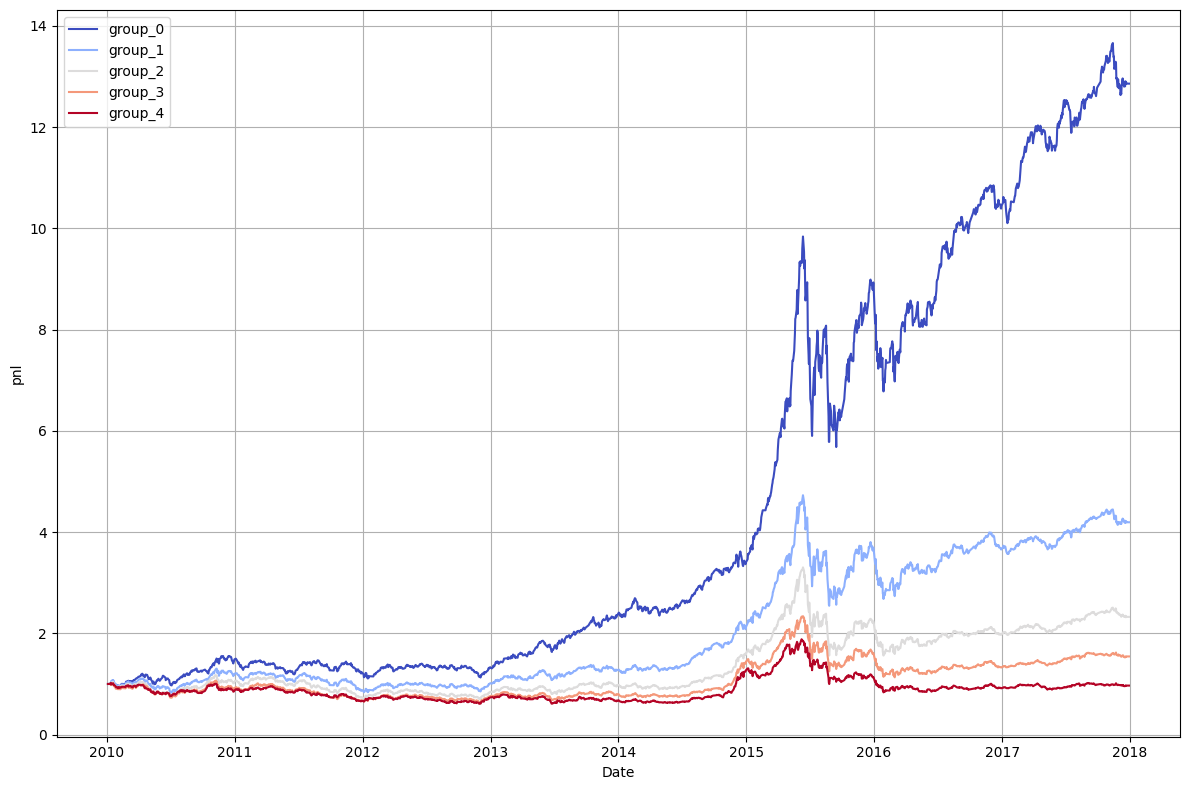

In [46]:
FactorMetrics.plot_pnl_by_groups((1+model.evaluate(integrated_factor, "group")).cumprod())

In [47]:
StrategyMetrics.annulized_sharpe_ratio(strategy_returns)

-1.6943872563661007

(<Figure size 1200x1000 with 2 Axes>,
 <Axes: title={'center': 'Monthly Returns Heatmap'}, xlabel='Month', ylabel='Year'>)

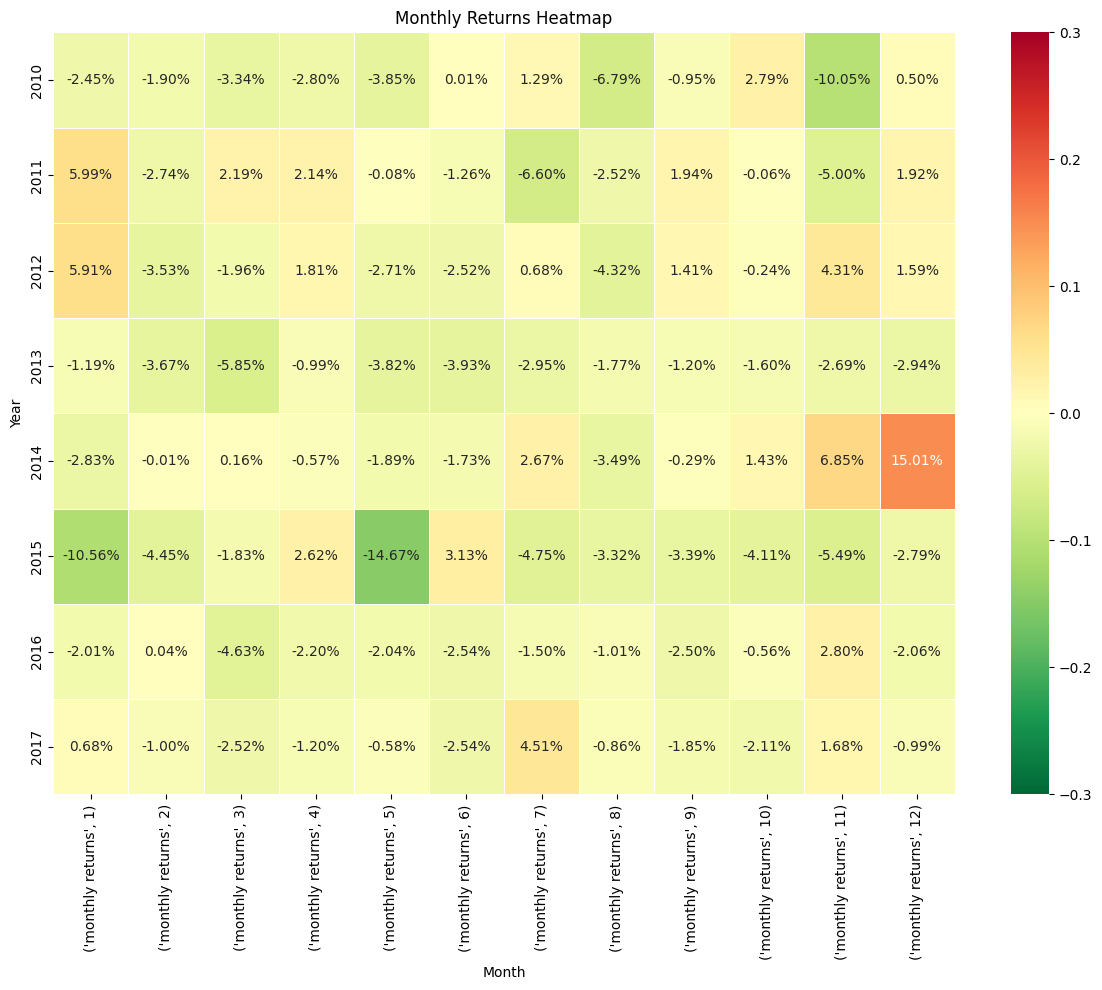

In [48]:
StrategyMetrics.plot_heatmap_of_monthly_returns(strategy_returns)

In [37]:
from alphagens.utils.visualization import ColorGenerator

In [42]:
ColorGenerator(5).data

['#3b4cc0', '#8db0fe', '#dddcdc', '#f4987a', '#b40426']

# 因子收益计算

In [16]:
# BP value
integrated_factor = get_clean_factor_and_current_returns(
    factor=1/data_portal.factor_get("PB", Context.REBALANCE_DATES),
    prices=data_portal.prices,
    quantiles=[0, 0.3, 0.7, 1],
)

In [8]:
integrated_factor

current_returns    factor group  factor_quantile
date       asset                                                   
2010-01-08 000001        -0.002196  0.271983    银行                3
           000002         0.006812  0.307050   房地产                3
           000060        -0.012183  0.126968  有色金属                1
           000063         0.004169  0.193341    通信                2
           000069         0.010769  0.118785   房地产                1
...                            ...       ...   ...              ...
2017-12-29 603160         0.019134  0.075933    电子                1
           603799        -0.011094  0.111198  有色金属                1
           603833         0.008371  0.123449  轻工制造                1
           603858         0.004942  0.364352  医药生物                2
           603993        -0.018547  0.250859  有色金属                1

[107806 rows x 4 columns]

In [28]:
def calculate_SMB(factor, prices, quantiles=[0, 0.3, 0.7, 1]):
    integrated_factor = get_clean_factor_and_current_returns(
        factor=factor,
        prices=prices,
        quantiles=quantiles,
    )
    def _aux_SMB(data):
        grouped_mean = data[["current_returns", "factor_quantile"]].groupby("factor_quantile").mean()
        return grouped_mean.loc[1] - grouped_mean.loc[len(quantiles)-1]
    result = integrated_factor.groupby("date").apply(lambda x:_aux_SMB(x))
    return pd.Series(result.values.reshape(-1), index=result.index, name="SMB")

def calculate_HML(factor, prices, quantiles=[0, 0.5, 1]):
    integrated_factor = get_clean_factor_and_current_returns(
        factor=factor,
        prices=prices,
        quantiles=quantiles,
    )
    def _aux_HML(data):
        grouped_mean = data[["current_returns", "factor_quantile"]].groupby("factor_quantile").mean()
        return grouped_mean.loc[len(quantiles)-1] - grouped_mean.loc[1]
    result = integrated_factor.groupby("date").apply(lambda x:_aux_HML(x))
    return pd.Series(result.values.reshape(-1), index=result.index, name="HML")

In [25]:
calculate_SMB(1/data_portal.factor_get("PB", Context.REBALANCE_DATES), data_portal.prices)

date
2010-01-08   -0.003999
2010-01-15    0.000317
2010-01-22   -0.018696
2010-01-29    0.008551
2010-02-05    0.007939
                ...   
2017-12-01    0.011109
2017-12-08    0.013395
2017-12-15   -0.001319
2017-12-22    0.000700
2017-12-29    0.003245
Name: SMB, Length: 408, dtype: float64

In [29]:
calculate_HML(data_portal.factor_get("LCAP", Context.REBALANCE_DATES), data_portal.prices)

date
2010-01-08   -0.006032
2010-01-15    0.000515
2010-01-22    0.011523
2010-01-29   -0.008348
2010-02-05   -0.002206
                ...   
2017-12-01   -0.003808
2017-12-08   -0.000322
2017-12-15   -0.007240
2017-12-22    0.000655
2017-12-29   -0.000343
Name: HML, Length: 408, dtype: float64

# 因子暴露计算 - 矩阵形式

In [32]:
# 因子暴露 
# 个股对因子收益进行回归